In [ ]:
from gfn.states import States
from gfn.utils.common import set_seed
from gfn.utils.modules import MLP  # is a simple multi-layer perceptron (MLP)
from torch.distributions import Distribution, Normal  # TODO: extend to Beta
from torch.distributions.independent import Independent
from tqdm import tqdm, trange
from gfn.modules import DiscretePolicyEstimator
from gfn.gflownet import TBGFlowNet
import torch
from torch import nn
from common.env import DistrictEnv
from common.pe_sampler import DistrictSampler, DistrictPolicyEstimator
import random
import math
from gfn.utils.handlers import is_callable_exception_handler
from common.probs_calc import get_trajectory_pfs_and_pbs


In [2]:
env = DistrictEnv(json_file="data/IA_raw_data.json", device_str="cpu")
device = env.device

In [3]:
env.district_graph.state.shape

torch.Size([99, 12])

In [4]:
fw_dim = env.state_shape[0]
n_actions = env.n_actions[0]
n_county = env.district_graph.num_county


class MLP_emb(torch.nn.Module):
    def __init__(self, input_dim, output_dim, trunk=None, emb=None):
        super().__init__()
        self.trunk = trunk
        d_model = 256

        if trunk is None:
            self.trunk = nn.Sequential(
                nn.Linear(input_dim, d_model),
                nn.ReLU(),
                nn.Linear(d_model, d_model//2),
                nn.ReLU(),
            )

        self.output = torch.nn.Linear(d_model//2, output_dim)

    def forward(self, x):
        out = self.trunk(x)
        return self.output(out)

module_PF = MLP_emb(fw_dim, n_actions).to(device)
module_PB = MLP_emb(fw_dim, n_actions - 1, trunk=module_PF.trunk).to(device)

In [5]:
pf_estimator = DistrictPolicyEstimator(module_PF, env.n_actions, is_backward=False, preprocessor=env.preprocessor)
pb_estimator = DistrictPolicyEstimator(module_PB, env.n_actions, is_backward=True, preprocessor=env.preprocessor)

In [ ]:
def get_pfs_and_pbs(
        self,
        trajectories,
        fill_value: float = 0.0,
        recalculate_all_logprobs: bool = False,
    ) :
        return get_trajectory_pfs_and_pbs(
            self.pf, self.pb, trajectories, fill_value, recalculate_all_logprobs
        )

In [6]:
gfn = TBGFlowNet(logZ=0., pf=pf_estimator, pb=pb_estimator)  # We initialize logZ to 0

gfn.get_pfs_and_pbs = get_pfs_and_pbs #.__get__(gfn)

# 5 - We define the sampler and the optimizer.
sampler = DistrictSampler(estimator=pf_estimator)  # We use an on-policy sampler, based on the forward policy

# Different policy parameters can have their own LR.
# Log Z gets dedicated learning rate (typically higher).
optimizer = torch.optim.Adam(gfn.pf_pb_parameters(), lr=1e-4)
optimizer.add_param_group({"params": gfn.logz_parameters(), "lr": 8e-2})

# 6 - We train the GFlowNet for 1000 iterations, with 16 trajectories per iteration
max_traj_len = 1
for i in (pbar := tqdm(range(1000))):
    trajectories = sampler.sample_trajectories(env=env, n=128, max_len=max_traj_len, epsilon=0.1)
    traj_len = trajectories.states.tensor.shape[0]
    if traj_len > max_traj_len:
        max_traj_len = traj_len
    optimizer.zero_grad()
    loss = gfn.loss(env, trajectories)
    loss.backward() 
    optimizer.step()
    # if i % 25 == 0:
    pbar.set_postfix({"loss": loss.item(), 'trajectories_len': (traj_len)})

 50%|█████     | 503/1000 [1:07:59<1:07:11,  8.11s/it, loss=81.2, trajectories_len=7]


KeyboardInterrupt: 

In [10]:
from utils.data_utils import (
    compute_compactness,
    compute_efficiency_gap,
    compute_partisan_bias,
    compute_population_entropy,
)


trajectories = sampler.sample_trajectories(env=env, n=512, max_len=max_traj_len)
results = []
for _idx, _graph in enumerate(trajectories.env.graphs):
            # log_rewards[_idx] = 100*step
            state = _graph.state
            s0_reshaped, _ = _graph.full_state_to_graph_state_taken_actions(_graph.s0)
            s0_diff = (state[:,0].abs() != s0_reshaped[:,0].abs()).sum().item()
            s0_diff_reward = min(s0_diff, 50)
            

            _df = trajectories.env.df_graphs[_idx]
            _df['test'] = state[:,0].cpu().abs().numpy()

            partisan_biais = compute_partisan_bias(_df,  _df['test'], dem_vote_col="pre_20_dem_bid", rep_vote_col="pre_20_rep_tru", v=0.5)
            compactness_mean, compactness_std = compute_compactness(_df, _df['test'])
            # compactness = compactness_mean - compactness_std

            eff_gap = abs(compute_efficiency_gap(_df,  _df['test'], dem_vote_col="pre_20_dem_bid", rep_vote_col="pre_20_rep_tru"))
            pop_entropy =  compute_population_entropy(_df,  _df['test'], population_col="pop")
            results.append((s0_diff_reward, partisan_biais, eff_gap, compactness_mean, compactness_std, pop_entropy))


In [11]:
import pandas as pd 
_results_df = pd.DataFrame(results, columns=["s0_diff_reward", "partisan_biais", "eff_gap", "compactness_mean", "compactness_std", "pop_entropy"])

In [15]:
_results_df.sort_values(by="eff_gap", ascending=True).head(40)

,s0_diff_reward,partisan_biais,eff_gap,compactness_mean,compactness_std,pop_entropy
206,2,-0.0,0.000095,0.350494,0.060819,1.277218
48,2,-0.0,0.000095,0.350494,0.060819,1.277218
207,2,-0.0,0.000095,0.350494,0.060819,1.277218
58,2,-0.0,0.000095,0.350494,0.060819,1.277218
385,2,-0.0,0.000095,0.350494,0.060819,1.277218
289,2,-0.0,0.000095,0.350494,0.060819,1.277218
196,2,-0.0,0.000095,0.350494,0.060819,1.277218
419,2,-0.0,0.000095,0.350494,0.060819,1.277218
461,2,-0.0,0.000095,0.350494,0.060819,1.277218
322,2,-0.0,0.000095,0.350494,0.060819,1.277218


In [16]:
idx_max = 0
max_reward = results[0]
for idx, res in enumerate(results):
    if abs(res[1]) < abs(max_reward[1]):
        if abs(res[2]) < abs(max_reward[2]):
            max_reward = res
            idx_max = idx

In [21]:
idx_max = 325

In [22]:
max_reward

(5,
 -0.0,
 0.036041517351791855,
 0.34576864556424736,
 0.06058884220858704,
 1.2531696893055837)

In [23]:
env.graphs[idx_max].state

tensor([[ 3.,  1., 38.,  ...,  0.,  0.,  0.],
        [ 3.,  0., 68.,  ...,  0.,  0.,  0.],
        [ 2., 21., 95.,  ...,  0.,  0.,  0.],
        ...,
        [ 4., 17., 66.,  ...,  0.,  0.,  0.],
        [-2., 16., 65.,  ...,  0.,  0.,  1.],
        [ 4., 34., 39.,  ...,  0.,  0.,  0.]])

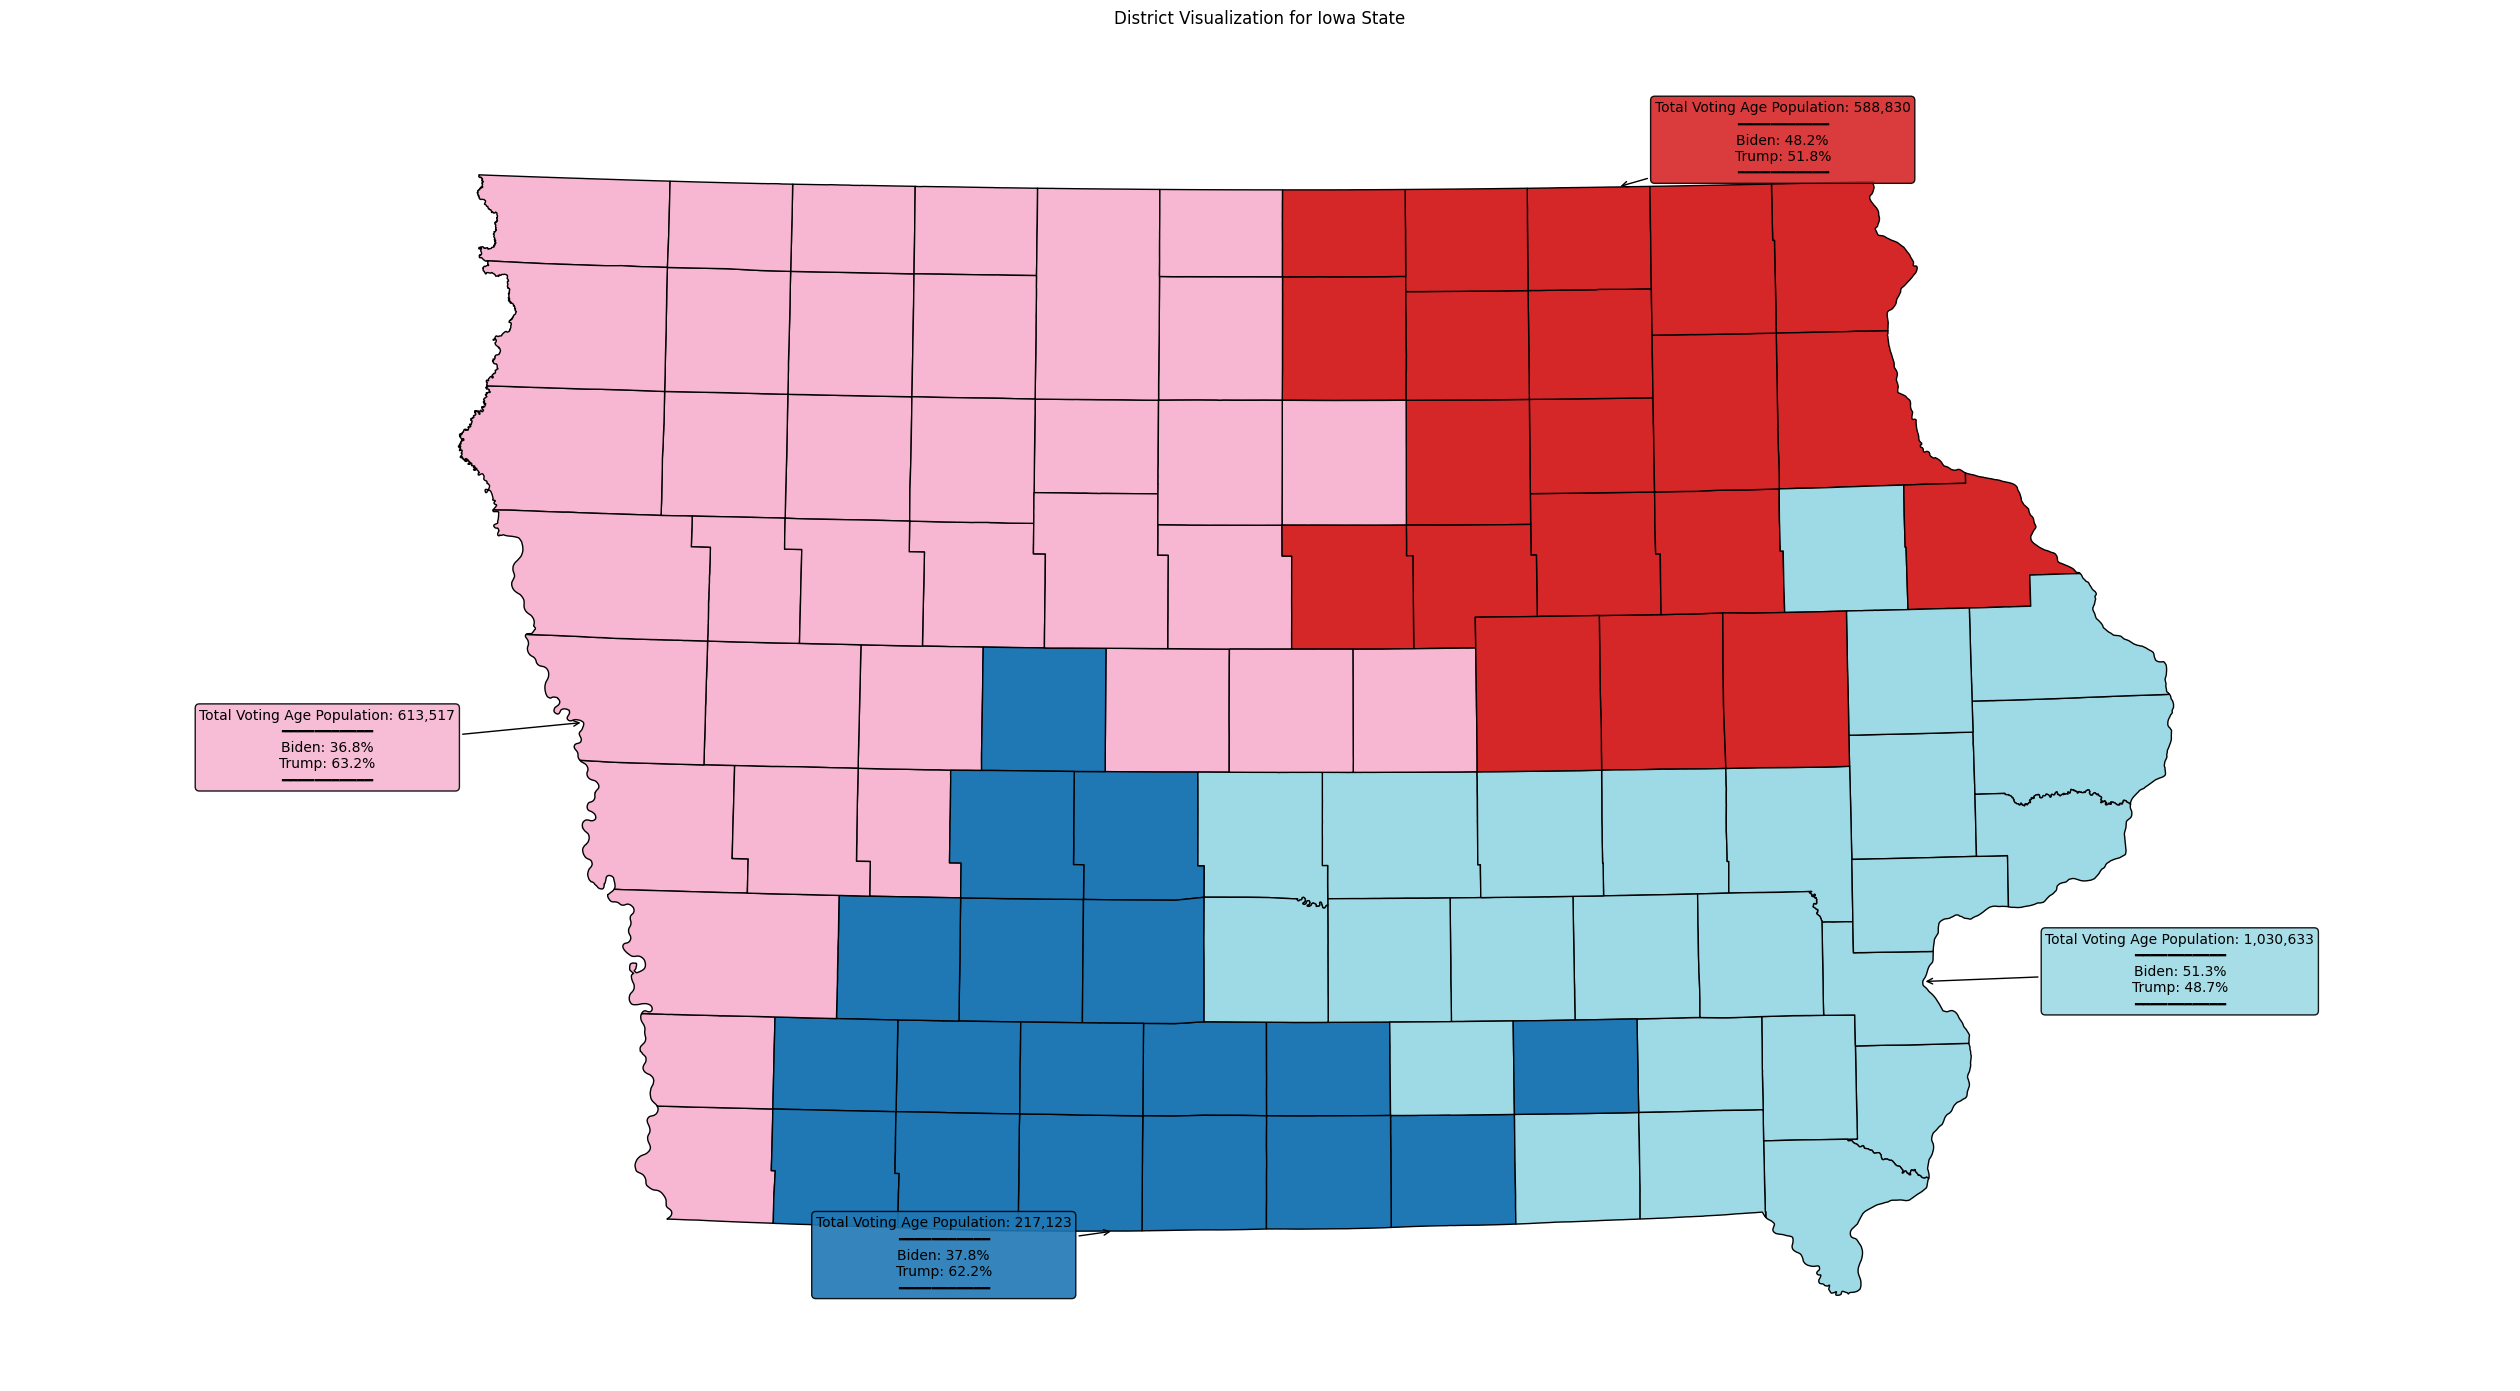

In [24]:
from utils.data_utils import load_raw_data, visualize_map_with_geometry
import numpy as np
df = trajectories.env.df_graphs[0]

state = env.graphs[idx_max].state


df['new_district_id'] = state[:, 0].cpu().abs().numpy()

metrics = {
    "total": [("vap", "Voting Age Population")],
    "mean": [],
    "ratio": [[("pre_20_dem_bid", "Biden"), ("pre_20_rep_tru", "Trump")]]
}
visualize_map_with_geometry(df, district_id_col="new_district_id", state="Iowa", geometry_col="geometry", metrics=metrics)

In [18]:
trajectories[-1].states[1].tensor.shape

torch.Size([1, 1584])

In [19]:
state.shape

torch.Size([99, 12])